In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

%matplotlib inline

In [42]:
# Load dataset dan simpan salinan
adult_income = fetch_openml(name='adult', version=1, as_frame=True)
df = adult_income.frame
#df_raw = df.copy()
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


([0, 1], [Text(0, 0, '<=50K'), Text(1, 0, '>50K')])

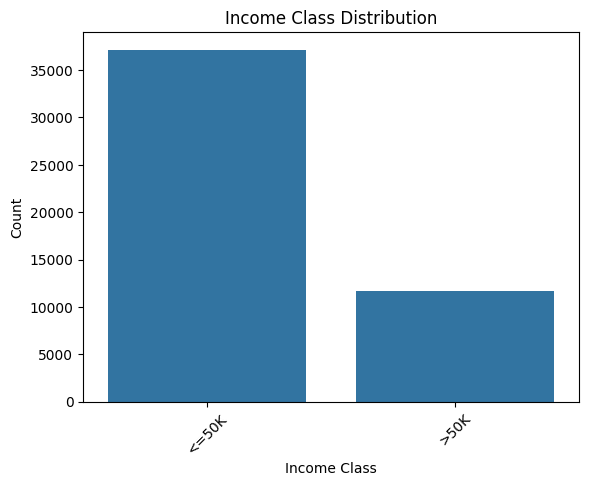

In [43]:
# Visualisasi distribusi kelas original (0–10)
sns.countplot(x=df['class'])
plt.title('Income Class Distribution')
plt.xlabel('Income Class')
plt.ylabel('Count') 
plt.xticks(rotation=45)

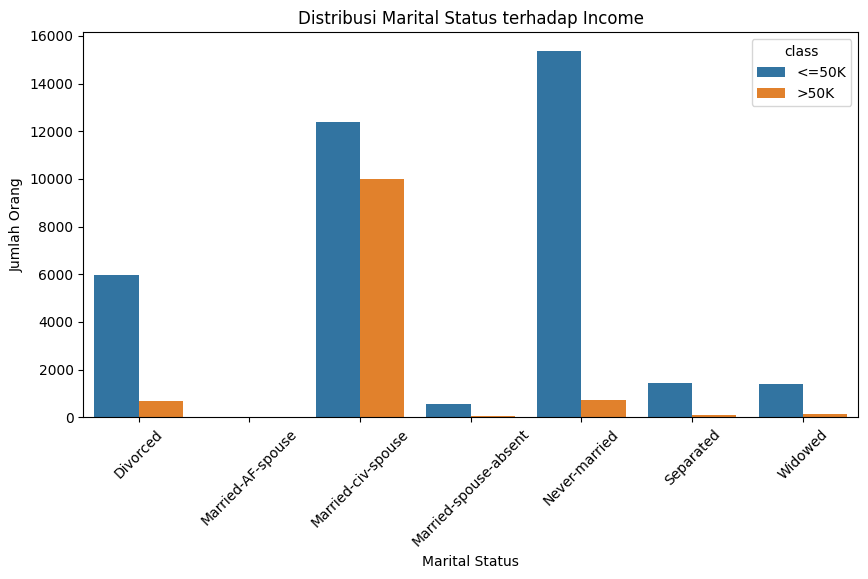

In [44]:
# Visualisasi distribusi marital-status
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='marital-status', hue='class')
plt.title('Distribusi Marital Status terhadap Income')
plt.xlabel('Marital Status')
plt.ylabel('Jumlah Orang')
plt.xticks(rotation=45)
#plt.tight_layout()
plt.show()

In [45]:
# Binarisasi target: <=50K = buruk (0), >50K = bagus (1)
df['target'] = (df['class'] == '>50K').astype(int)
income_dist = pd.crosstab(df['marital-status'], df['target'])
income_dist.columns = ['<=50K (0)', '>50K (1)']
income_dist
df['target'].value_counts()

target
0    37155
1    11687
Name: count, dtype: int64

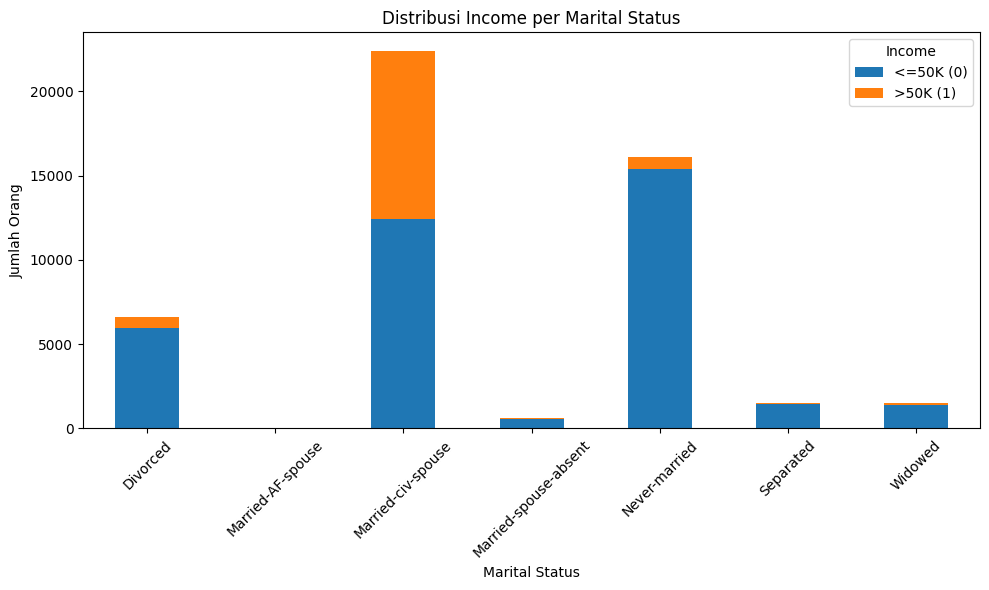

In [46]:
income_dist.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Distribusi Income per Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Jumlah Orang')
plt.legend(title='Income')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['target', 'class'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [48]:
from sklearn.linear_model import LogisticRegression

# Untuk model sederhana, kita gunakan Logistic Regression
model = LogisticRegression(max_iter=1000)
# Untuk data kategori, kita perlu mengubah ke numerik (one-hot encoding)
X_train_enc = pd.get_dummies(X_train)
X_test_enc = pd.get_dummies(X_test)
# Pastikan kolom sama antara train dan test
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

model.fit(X_train_enc, y_train)

# Tambahkan kolom marital-status ke X_test
X_test_with_status = X_test.copy()
X_test_with_status['marital-status'] = df.loc[X_test.index, 'marital-status']

# Buat prediksi pada data uji
y_pred = model.predict(X_test_enc)

# Gabungkan hasil prediksi
result_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'MaritalStatus': X_test_with_status['marital-status']
})

# Evaluasi performa model untuk tiap marital status
from sklearn.metrics import classification_report
grouped_report = result_df.groupby('MaritalStatus').apply(
    lambda g: pd.Series(classification_report(g['Actual'], g['Predicted'], output_dict=True)['weighted avg'])
)

# Tampilkan hasil evaluasi
grouped_report[['precision', 'recall', 'f1-score']].round(3)

/Users/risyadriyadi/AI-Project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/c_/l21mfmcj3yd07_crqhrn1_k40000gp/T/ipykernel_2524/2136131363.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_report = result_df.groupby('MaritalStatus').apply(
/Users/ri

,precision,recall,f1-score
MaritalStatus,,,
Divorced,0.926,0.933,0.920
Married-AF-spouse,0.444,0.667,0.533
Married-civ-spouse,0.743,0.742,0.739
Married-spouse-absent,0.941,0.937,0.926
Never-married,0.958,0.964,0.955
Separated,0.952,0.949,0.939
Widowed,0.944,0.949,0.941
